# Test the detector linearity
This notebook looks at the detector linearity as a function of the caracteristics of the external source (amplitude, offset). 

In [22]:
#%matplotlib notebook
%matplotlib inline
from matplotlib import rc
rc('figure', figsize=(10,7))
rc('font', size=12)
rc('text', usetex=False)

from qubicpack import qubicpack as qp
import fibtools as ft
import plotters as p

import numpy as np
from matplotlib.pyplot import *
import matplotlib.mlab as mlab
import scipy.ndimage.filters as f
import glob
import string

There are two datasets to be analyzed:
- *linearityA* : offset is always 1V and we go from 0.5V to 2V amplitude. In this dataset the modulation does not always reach zero amplitude for the source.
- *linearityB* : Amplitude is always 2xOffset so that the modulation always goes from 0 to Amplitude 

In the following cell we read the corresponding filenames and order them, detect the offsets, amplitudes and modulation frequencies. We order the files by the amplitude of the modulation.

In [23]:
day = '2019-03-01'
data_dir = '/qubic/Data/Calib-TD/'+day+'/'
dirs = np.array(glob.glob(data_dir+'/*LinearityA*'))
dirs.sort()

#dirs = dirs[0:-1]

print dirs
print ''
labels = []
for d in dirs:
    bla = str.split(d,'__')
    labels.append(bla[1])
labels = np.array(labels)

modfreqs = np.zeros(len(labels))
amps = np.zeros(len(labels))
offsets = np.zeros(len(labels))
for i in xrange(len(labels)):
    bla = str.split(labels[i],'_')
    modfreqs[i] = np.float(bla[2][0:len(bla[2])-2])
    amps[i] = np.float(bla[4])
    offsets[i] = np.float(bla[6])

    
order = np.argsort(amps)
modfreqs = modfreqs[order]
amps = amps[order]
offsets = offsets[order]
labels = labels[order]
dirs = dirs[order]
print ''
print(dirs)
print ''
print labels
print(amps)
print(offsets)
print(modfreqs)

['/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.38.21__LinearityA_sin_0.333Hz_amp_1.500_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.41.24__LinearityA_sin_0.333Hz_amp_1.750_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.44.29__LinearityA_sin_0.333Hz_amp_2.000_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.50.46__LinearityA_sin_0.333Hz_amp_3.000_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.53.34__LinearityA_sin_0.333Hz_amp_3.500_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.56.25__LinearityA_sin_0.333Hz_amp_4.000_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.59.19__LinearityA_sin_0.333Hz_amp_4.500_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_15.02.19__LinearityA_sin_0.333Hz_amp_5.000_off_2.500']


['/qubi

And there are source data associated, that are read below. It contains time (computer-time from the rasberry pi) and amplitude of the power-meter. We read them all for this day and concatenate them. Later we'll pick the common period corresponding to each data file.

['/qubic/Data/Calib-TD/calsource/calsource_20190301T133531.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T133828.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T134131.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T134435.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T134754.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T135053.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T135340.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T135631.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T135925.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T140226.dat']


Text(0,0.5,'ddsrc')

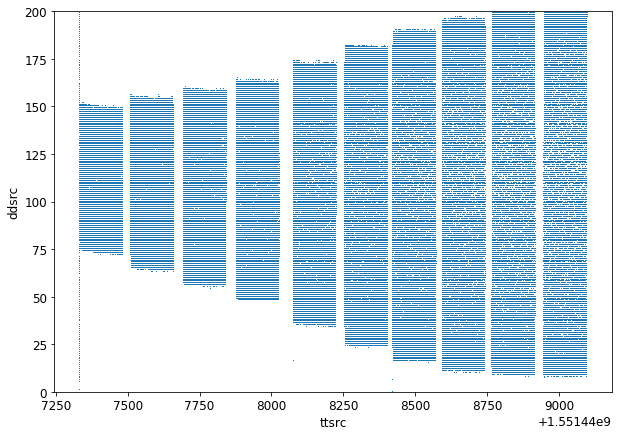

In [24]:
### The date format for calsrc has no '-' so we need to change the day to this very format.
daycalsrc = "".join(str.split(day,'-'))
fcalsrc = glob.glob('/qubic/Data/Calib-TD/calsource/*' + daycalsrc + '*')
fcalsrc.sort()
print fcalsrc

ttsrc = []
ddsrc = []
for ff in fcalsrc:
    thett, thedd = np.loadtxt(ff).T
    ttsrc.append(thett + 3600)
    ddsrc.append(thedd)
    
ttsrc = np.concatenate(ttsrc)
ddsrc = np.concatenate(ddsrc)

plot(ttsrc, ddsrc, ',')
ylim(0, 200)
xlabel('ttsrc')
ylabel('ddsrc')

Now we read the data, then we find the common time between data and calsrc, then we put this into lists for each of the file.

In [25]:
tt = []
dd = []
mm = []
tt_src = []
dd_src = []
temperatures = []
for thedir in dirs:
    print ''
    print(thedir)
    a = qp()
    asicnum = 1
    a.read_qubicstudio_dataset(thedir, asic=asicnum)
    temperatures.append(a.temperature)
    nsamples = len(a.timeline(TES=96))
    pow2 = int(np.log(nsamples)/np.log(2))
    ns = 2**pow2
    FREQ_SAMPLING = 1./a.sample_period()

    #### Old version: no PPS, data timeline is just a linspace
    t_data = a.timeline_timeaxis(axistype='index')
    t0 = a.timeline_timeaxis(axistype='pps')[0]
    t_data = t_data + t0
    #### NEW version with PPS accounted for
#     t_data = a.timeline_timeaxis(axistype='pps')
#     t0 = t_data[0]
    print('')
    print('DAta TIME:')
    print(thedir)
    # print(dt.datetime.fromtimestamp(np.min(t_data)))
    # print(dt.datetime.fromtimestamp(np.max(t_data)))
    # print('SRC TIME:')
    # print dt.datetime.fromtimestamp(np.min(ttsrc))
    # print dt.datetime.fromtimestamp(np.max(ttsrc))
    
    TESnum = 96
    data = a.timeline(TES=TESnum)


#     print t_data[0:10]-t0
#     print ttsrc[0:10]-t0
#     plot(t_data-t0, data, ',')
#     plot(ttsrc-t0, ddsrc*1000)

    ### Find the region where there is source data
    oksrc = (ttsrc >= (t_data[0])) & (ttsrc <=(t_data[-1]))
    print 'Number of common points: {}'.format(oksrc.sum())
    thettsrc = ttsrc[oksrc]
    theddsrc = ddsrc[oksrc]
    
    
    ### now reduce each to matching regions
    print [np.min(t_data), np.min(thettsrc)]
    mini = np.max([np.min(t_data), np.min(thettsrc)])
    maxi = np.min([np.max(t_data), np.max(thettsrc)])
    okdata = (t_data >= mini) & (t_data <= maxi)
    oksrc = (thettsrc >= mini) & (thettsrc <= maxi)
    t_data = t_data[okdata]
    data = data[okdata]
    thettsrc = thettsrc[oksrc]
    theddsrc = theddsrc[oksrc]
        
    tt.append(t_data - t0)
    dd.append(data)
    mm.append(np.mean(data))
    tt_src.append(thettsrc - t0)
    dd_src.append(theddsrc)



/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Sums/science-asic1-2019.03.01.143525.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Sums/science-asic1-2019.03.01.143525.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Hks/hk-intern-2019.03.01.143529.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Hks/hk-intern-2019.03.01.143529.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.2

mean separation between pulses is 1.00 second
setting pps interval to 1 second

DAta TIME:
/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.44.29__LinearityA_sin_0.333Hz_amp_2.000_off_2.500
Number of common points: 31731
[1551447876.8269231, 1551447876.830882]

/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Sums/science-asic1-2019.03.01.144748.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Sums/science-asic1-2019.03.01.144748.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Hks/hk-inter

mean separation between pulses is 0.99 second
setting pps interval to 0 second

DAta TIME:
/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.56.25__LinearityA_sin_0.333Hz_amp_4.000_off_2.500
Number of common points: 31875
[1551448594.0, 1551448594.002886]

/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.59.19__LinearityA_sin_0.333Hz_amp_4.500_off_2.500
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.59.19__LinearityA_sin_0.333Hz_amp_4.500_off_2.500/Sums/science-asic1-2019.03.01.145919.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.59.19__LinearityA_sin_0.333Hz_amp_4.500_off_2.500/Sums/science-asic1-2019.03.01.145919.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.59.19__LinearityA_sin_0.333Hz_amp_4.500_off_2.500/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.59.19__LinearityA_sin_0.333Hz_amp_4.500_off_2.500/Hks/hk-intern-2019

Next cell displays the power-spectra of the data and calsrc. Beware that CalSrc is not evenly sampled so it's mandatory to resample it on a regular grid before taking the FFT.

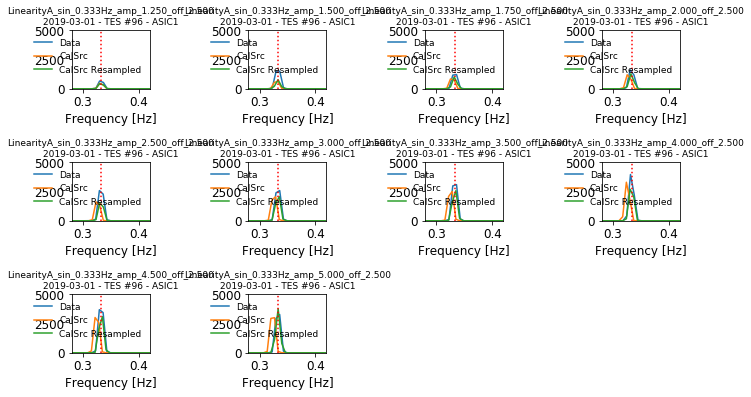

In [27]:
npl = int(np.sqrt(len(tt))) + 1
fdata = 0.0001
fsrc = 0.0001
for ii in xrange(len(dd_src)):
    subplot(npl, npl, ii+1)
    spectrum_src, freq_src = mlab.psd(dd_src[ii], Fs=1./np.mean(tt_src[0][1:]-tt_src[0][:-1]), 
                                      NFFT=len(tt_src[ii]), window=mlab.window_hanning)
    spectrum, freq = mlab.psd(dd[ii], Fs=FREQ_SAMPLING, NFFT=len(tt[ii]), window=mlab.window_hanning)
    
    ## Resampling calsrc data
    newtime_src = np.arange(len(dd_src[ii]))*np.mean(tt_src[0][1:]-tt_src[0][:-1])
    newdata_src = np.interp(newtime_src, tt_src[ii], dd_src[ii])
    spectrum_src2, freq_src2 = mlab.psd(newdata_src, Fs=1./np.mean(tt_src[0][1:]-tt_src[0][:-1]), 
                                        NFFT=len(tt_src[ii]), window=mlab.window_hanning)
    
    plot(freq, f.gaussian_filter1d(spectrum,fdata)/np.mean(spectrum), label='Data')
    plot(freq_src, f.gaussian_filter1d(spectrum_src,fsrc)/np.mean(spectrum_src), label='CalSrc')
    plot(freq_src2, f.gaussian_filter1d(spectrum_src2,fsrc)/np.mean(spectrum_src2), label='CalSrc Resampled')
    legend(fontsize=9, frameon=False)
    xlim(0.28, 0.42)
    ylim(0, 5000)
    xlabel('Frequency [Hz]')
    plot([0.333,0.333], [0,5000], 'r:')
    title(labels[ii]+'\n'+day+' - TES #{} - ASIC{}'.format(TESnum, asicnum),fontsize=9)

tight_layout()

We now fold the data and the CalSrc over one period, then fit a sinewave on the folded data.

NB: we reverse signs for the calsrc and the data here in order to have positive signal when the source is up.

In [28]:
def sine(x,pars):
    return 0.5*np.sqrt(pars[0]**2)*np.sin(2*np.pi*(x-pars[2])/pars[1])+pars[3]

reload(ft)
nbins = 50
allfolded = np.zeros((len(tt), nbins))
allfolded_src = np.zeros((len(tt), nbins))
allresfit = np.zeros((len(tt), 4))
allerrfit = np.zeros((len(tt), 4))
for ii in xrange(len(tt)):
    ns = len(tt[ii])
    #modulation_frequency = modfreqs[ii]
    modulation_frequency = 0.333
    guess = np.array([5000.*amps[ii], 1./modulation_frequency, 1.,0.])
    folded, t, folded_nonorm, dy = ft.fold_data(tt[ii], -np.reshape(dd[ii], (1,ns)), 
                                            1./modulation_frequency, 0.01, 100., nbins, notch=None, return_error=True)
    folded_src, tsrc, folded_nonorm_src, dy_src = ft.fold_data(tt_src[ii], -np.reshape(dd_src[ii], (1,len(dd_src[ii]))), 
                                            1./modulation_frequency, 0.01, 100., nbins, notch=None, return_error=True)
    allfolded[ii,:] = folded_nonorm
    allfolded_src[ii,:] = folded_nonorm_src
    
    
    res = ft.do_minuit(t,allfolded[ii,:],dy, 
                       guess, functname=sine, fixpars=[0,1,0,0],verbose=False, force_chi2_ndf=True)
    allresfit[ii,:] = res[1]
    allerrfit[ii,:] = res[2]


Detectors 100%[==================================================]Time: 0:00:00


FCN = 65.4416420614 
 TOTAL NCALL = 61 
 NCALLS = 61 
 
 
 EDM = 3.00008123885e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,4.912675e+04,3.227285e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,1.019049e+00,3.091930e-03,0.000000e+00,0.000000e+00,,,
4,c3,9.001147e+00,1.133629e+02,0.000000e+00,0.000000e+00,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,4.912675e+04,3.227285e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,1.019049e+00,3.091930e-03,0.000000e+00,0.000000e+00,,,
4,c3,9.001147e+00,1.133629e+02,0.000000e+00,0.000000e+00,,,


+,c0,c2,c3
c0,1.00,-0.01,0.04
c2,-0.01,1.00,-0.06
c3,0.04,-0.06,1.00


Detectors 100%[==================================================]Time: 0:00:00


FCN = 133.252471385 
 TOTAL NCALL = 81 
 NCALLS = 81 
 
 
 EDM = 3.08007391699e-10 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,5.954770e+04,2.987795e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,2.272732e+00,2.379924e-03,0.000000e+00,0.000000e+00,,,
4,c3,6.019889e+00,1.052444e+02,0.000000e+00,0.000000e+00,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,5.954770e+04,2.987795e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,2.272732e+00,2.379924e-03,0.000000e+00,0.000000e+00,,,
4,c3,6.019889e+00,1.052444e+02,0.000000e+00,0.000000e+00,,,


+,c0,c2,c3
c0,1.00,-0.01,0.02
c2,-0.01,1.00,0.02
c3,0.02,0.02,1.00


Detectors 100%[==================================================]Time: 0:00:00


FCN = 145.177397134 
 TOTAL NCALL = 69 
 NCALLS = 69 
 
 
 EDM = 2.77031694752e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.967613e+04,3.455506e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,8.237949e-01,2.342504e-03,0.000000e+00,0.000000e+00,,,
4,c3,2.522713e+01,1.216075e+02,0.000000e+00,0.000000e+00,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.967613e+04,3.455506e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,8.237949e-01,2.342504e-03,0.000000e+00,0.000000e+00,,,
4,c3,2.522713e+01,1.216075e+02,0.000000e+00,0.000000e+00,,,


+,c0,c2,c3
c0,1.00,0.01,0.05
c2,0.01,1.00,0.05
c3,0.05,0.05,1.00


Detectors 100%[==================================================]Time: 0:00:00


FCN = 259.745669477 
 TOTAL NCALL = 76 
 NCALLS = 76 
 
 
 EDM = 2.78119260629e-12 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,7.753825e+04,4.059643e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,1.486891e-01,2.510290e-03,0.000000e+00,0.000000e+00,,,
4,c3,-1.392846e+01,1.437565e+02,0.000000e+00,0.000000e+00,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,7.753825e+04,4.059643e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,1.486891e-01,2.510290e-03,0.000000e+00,0.000000e+00,,,
4,c3,-1.392846e+01,1.437565e+02,0.000000e+00,0.000000e+00,,,


+,c0,c2,c3
c0,1.00,0.01,-0.01
c2,0.01,1.00,0.01
c3,-0.01,0.01,1.00



Detectors 100%[==================================================]Time: 0:00:00


FCN = 1333.41306777 
 TOTAL NCALL = 60 
 NCALLS = 60 
 
 
 EDM = 5.89375840219e-10 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,9.472820e+04,2.402207e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,1.031066e+00,1.227897e-03,0.000000e+00,0.000000e+00,,,
4,c3,-7.054254e+01,8.548347e+01,0.000000e+00,0.000000e+00,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,9.472820e+04,2.402207e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,1.031066e+00,1.227897e-03,0.000000e+00,0.000000e+00,,,
4,c3,-7.054254e+01,8.548347e+01,0.000000e+00,0.000000e+00,,,


+,c0,c2,c3
c0,1.00,0.00,0.00
c2,0.00,1.00,0.01
c3,0.00,0.01,1.00



Detectors 100%[==================================================]Time: 0:00:00


FCN = 1009.09239117 
 TOTAL NCALL = 70 
 NCALLS = 70 
 
 
 EDM = 2.37123593305e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,1.089912e+05,3.193515e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,-1.398045e-01,1.411107e-03,0.000000e+00,0.000000e+00,,,
4,c3,-2.106349e+01,1.133298e+02,0.000000e+00,0.000000e+00,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,1.089912e+05,3.193515e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,-1.398045e-01,1.411107e-03,0.000000e+00,0.000000e+00,,,
4,c3,-2.106349e+01,1.133298e+02,0.000000e+00,0.000000e+00,,,


+,c0,c2,c3
c0,1.00,0.01,-0.00
c2,0.01,1.00,-0.01
c3,-0.00,-0.01,1.00



Detectors 100%[==================================================]Time: 0:00:00


FCN = 1773.11407242 
 TOTAL NCALL = 78 
 NCALLS = 78 
 
 
 EDM = 1.20006737e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,1.219802e+05,2.676631e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,-4.576203e-01,1.023449e-03,0.000000e+00,0.000000e+00,,,
4,c3,6.264750e+01,9.357458e+01,0.000000e+00,0.000000e+00,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,1.219802e+05,2.676631e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,-4.576203e-01,1.023449e-03,0.000000e+00,0.000000e+00,,,
4,c3,6.264750e+01,9.357458e+01,0.000000e+00,0.000000e+00,,,


+,c0,c2,c3
c0,1.00,0.01,0.04
c2,0.01,1.00,0.06
c3,0.04,0.06,1.00


FCN = 1547.90381814 
 TOTAL NCALL = 73 
 NCALLS = 73 
 
 
 EDM = 4.70107859179e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,1.292579e+05,3.169850e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,6.293567e-01,1.183960e-03,0.000000e+00,0.000000e+00,,,
4,c3,7.415833e+01,1.127579e+02,0.000000e+00,0.000000e+00,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,1.292579e+05,3.169850e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,6.293567e-01,1.183960e-03,0.000000e+00,0.000000e+00,,,
4,c3,7.415833e+01,1.127579e+02,0.000000e+00,0.000000e+00,,,


+,c0,c2,c3
c0,1.00,-0.00,-0.04
c2,-0.00,1.00,0.05
c3,-0.04,0.05,1.00


FCN = 2515.80300982 
 TOTAL NCALL = 75 
 NCALLS = 75 
 
 
 EDM = 3.45040348175e-11 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,1.352857e+05,2.995163e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,5.443381e-01,1.045374e-03,0.000000e+00,0.000000e+00,,,
4,c3,1.196108e+02,1.055486e+02,0.000000e+00,0.000000e+00,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,1.352857e+05,2.995080e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,5.443381e-01,1.045373e-03,0.000000e+00,0.000000e+00,,,
4,c3,1.196108e+02,1.055569e+02,0.000000e+00,0.000000e+00,,,


+,c0,c2,c3
c0,1.00,0.01,0.09
c2,0.01,1.00,-0.05
c3,0.09,-0.05,1.00


FCN = 3455.89140141 
 TOTAL NCALL = 70 
 NCALLS = 70 
 
 
 EDM = 1.1082995643e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,1.392121e+05,2.992640e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,1.506184e+00,1.025336e-03,0.000000e+00,0.000000e+00,,,
4,c3,-7.305888e+01,1.055529e+02,0.000000e+00,0.000000e+00,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,1.392121e+05,2.974530e+02,0.000000e+00,0.000000e+00,,,
2,c1,3.003003e+00,1.000000e+00,0.000000e+00,0.000000e+00,,,FIXED
3,c2,1.506184e+00,1.024584e-03,0.000000e+00,0.000000e+00,,,
4,c3,-7.305888e+01,1.054151e+02,0.000000e+00,0.000000e+00,,,


+,c0,c2,c3
c0,1.00,0.02,0.06
c2,0.02,1.00,-0.00
c3,0.06,-0.00,1.00


Next cell is just a plot of the previous calculations. Normally one sees the saturation effect on the calsrc and the data for some of the files.

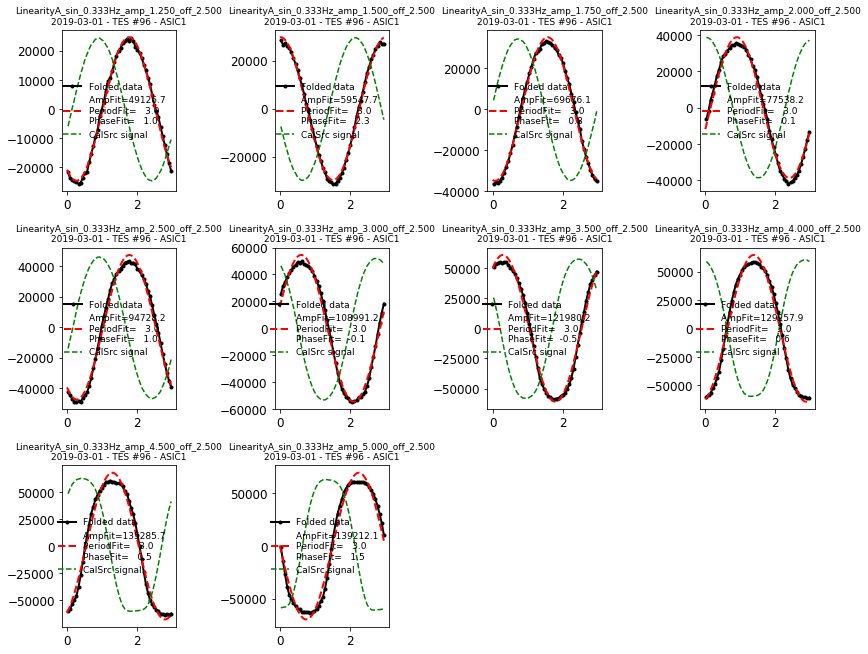

In [30]:
npl = int(np.sqrt(len(tt))) + 1
rc('figure', figsize=(12,12))
ttt = np.linspace(0, np.max(t), 1000)
for ii in xrange(len(tt)):
    subplot(npl, npl, ii+1)
    p = plot(t, allfolded[ii,:], 'k.-', lw=2, label='Folded data')
    plot(ttt, sine(ttt, allresfit[ii,:]),'r--', lw=2, 
           label='AmpFit={0:6.1f} \nPeriodFit={1:6.1f} \nPhaseFit={2:6.1f}'.format(allresfit[ii,0],
                                                                                   allresfit[ii,1],
                                                                                   allresfit[ii,2]))
    p = plot(tsrc, -allfolded_src[ii,:]/np.std(allfolded_src[ii,:])*np.std(allfolded[ii,:]),'g--', 
             label='CalSrc signal')
    title(labels[ii]+'\n'+day+' - TES #{} - ASIC{}'.format(TESnum, asicnum),fontsize=9)
    legend(fontsize=9, frameon=False)
tight_layout() 

Now accounting for the intrinsic saturation of the source (code by Daniele Mennella)

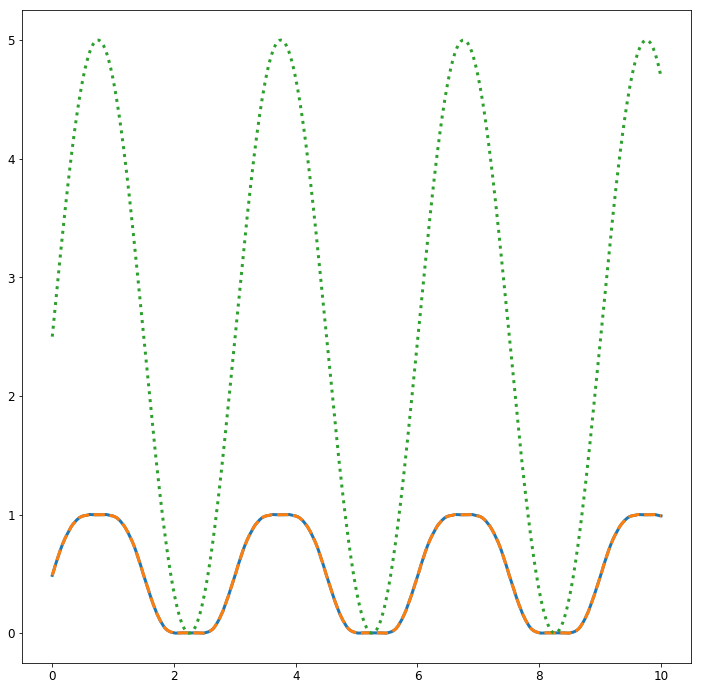

In [31]:
def source_cal(Vin, freq = 150., folder = '/qubic/Data/Calib-TD/calsource'):
    import scipy as sc

    '''
    This function interpolates the source calibration curve and returns an interpolated value at any point

    INPUTS
    Vin    - FLOAT - the input voltage [V]
    freq   - FLOAT - the RF frequency (default = 150 GHz)
    folder - STRING - the folder containing the calibration curve

    OUTPUTS
    result  - FLOAT - the interpolated value at Vin

    '''

    calibration_file = '%s/source_calibration_curve_%sGHz.txt' % (folder,int(freq))
    data = np.transpose(np.loadtxt(calibration_file))
    if Vin <= data[0][0]:
     out = data[1][0]
    elif Vin >= data[0][-1]:
     out = data[1][-1]
    else:
     fint = sc.interpolate.interp1d(data[0],data[1])
     out = fint(Vin)
    return out



def sim_generator_power(time, amplitude, offset, frequency, phase, 
rf_freq = 150.):

    '''
    This function simulates the power output of the source
    taking into account the source calibration curve

    INPUTS
    time      - FLOAT - the current time [s]
    amplitude - FLOAT - the p2p amplitude of the signal in the UCA stage of the generator [V]
    offset    - FLOAT - the offset of the signal in the UCA stage of the generator [V]
    frequency - FLOAT - the modulation frequency [Hz]
    phase     - FLOAT - the wave initial phase
    rf_freq   - FLOAT - the RF frequency (chosen to select the right calibration curve, defaults to 150 GHz)

    OUTPUTS
    uncal_signal, cal_signal  - FLOAT - the uncalibrated signal and the calibrated signal
                                     (percentage of max output power)interpolated value at Vin

    '''

    if type(time) == float:
     tim = np.array([time])
    else:
     tim = time
    sine = amplitude/2. * np.sin(2.*np.pi * frequency * tim + phase) # Divide by 2 because we provide the p2p
    uncal_signal = sine + offset
    cal_signal = np.array([source_cal(i) for i in uncal_signal])
    return cal_signal

def sinesat(x,pars):
    return sim_generator_power(x, pars[0], pars[3], 1./pars[1], pars[2])

ttt = np.linspace(0, 10, 1000)
plot(ttt, sim_generator_power(ttt, 5., 2.5, 0.333, 0.), lw=3)

plot(ttt, sinesat(ttt, [5., 1./0.333,0., 2.5]),'--', lw=3)
plot(ttt, sine(ttt, [5., 1./0.333,0., 2.5]),':', lw=3)

Here we plot the amplitude of the fitted sinewave as a function of the input modulation. The saturation effect might be seen for large modulation amplitude.

(array([ 49126.74634148,  59547.70065046,  69676.13003608,  77538.24978968,
        94728.20149252, 108991.21250984, 121980.22400501, 129257.86668599,
       135285.6702215 , 139212.12128827]), array([ 384.93325778,  508.52167472,  613.87817438,  964.67961735,
       1293.34319199, 1495.73778029, 1661.7969982 , 1838.78832493,
       2214.97019772, 2578.21736636]))
Fitting with Minuit


FCN = 7668.04986274 
 TOTAL NCALL = 95 
 NCALLS = 82 
 
 
 EDM = 10220.0229699 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.501436e+04,2.597785e+02,0.000000e+00,0.000000e+00,,,
2,c1,9.809423e-01,4.547854e-03,0.000000e+00,0.000000e+00,,,
3,c2,7.801248e-03,1.301108e-04,0.000000e+00,0.000000e+00,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.501436e+04,2.490395e+02,0.000000e+00,0.000000e+00,,,
2,c1,9.809423e-01,1.214862e-02,0.000000e+00,0.000000e+00,,,
3,c2,7.801248e-03,2.996270e-04,0.000000e+00,0.000000e+00,,,


+,c0,c1,c2
c0,1.00,0.13,0.01
c1,0.13,1.00,-0.01
c2,0.01,-0.01,1.00


correcting errorbars to have chi2/ndf=1 - correction = 7668.04986274
[6.50143562e+04 9.80942319e-01 7.80124794e-03]
[8.24255310e+03 4.02087312e-01 9.91686559e-03]
('Chi2=', 7668.04986274045)
('ndf=', 7)


Text(0,0.5,'Recovered Amplitude')

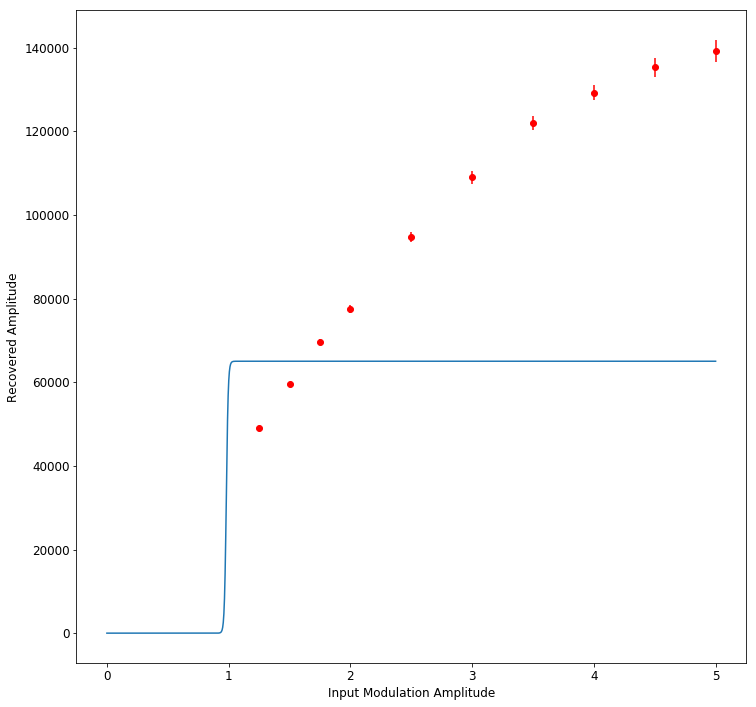

In [32]:
print(allresfit[:,0],allerrfit[:,0])
xxx = np.linspace(0,np.max(amps),1000)

def logistic(x,pars):
    return pars[0]*1./(1+np.exp(-(x-pars[1])/pars[2]))

guess = np.array([14000.,1.,1.])
res = ft.do_minuit(amps,np.abs(allresfit[:,0]),allerrfit[:,0], 
                   guess, functname=logistic,verbose=True, force_chi2_ndf=True)

errorbar(amps, np.abs(allresfit[:,0]), yerr=allerrfit[:,0], fmt='ro')
plot(xxx, logistic(xxx,res[1]))
xlabel('Input Modulation Amplitude')
ylabel('Recovered Amplitude')
#xscale('log')
#xlim(np.min(amps), np.max(amps))

In fact what we want is to see the output of the TES as a function of the input power. So this is what we do in the next cell. The input power can be chosen form the input sinewave (that does not contain the intrinsic non-linearity of the source) or the calsrc data. Of course the latter is the relevant one.

We fit one Vs the other with a linear law (should surely be improved in the future).

The result makes sense when using the Sinewave fitted on the data: we see a clear saturation for the high values of the src.  But it is a mixture of that of the source and that of the TES. The result makes less sense (for now) if we take the CalSrc data Vs Data.

In [223]:
allres = np.zeros((2,len(tt)))
allerr = np.zeros((2,len(tt)))
for ii in xrange(len(tt)):
    params = np.array([amps[ii]/2, 1./modfreqs[ii], allresfit[ii,2]])
    #### With fitted sinewave
#     input_type = 'Fitted sinewave'
#     input_curve = sine(t, params)+offsets[ii]
    #### With calsrc signal
    input_type = 'CalSrc Signal'
    input_curve = -allfolded_src[ii,:]
    res = ft.do_minuit(input_curve, allfolded[ii,:],np.zeros(len(t))+1., 
                   np.array([0.,10000.]), functname=ft.thepolynomial,verbose=False, force_chi2_ndf=True)
    allres[:,ii] = res[1]
    allerr[:,ii] = res[2]


FCN = 219412545.259 
 TOTAL NCALL = 24 
 NCALLS = 24 
 
 
 EDM = 4.23218490808e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,3.423366e+03,2.745482e-02,0.000000e+00,0.000000e+00,,,
2,c1,5.801510e-06,1.414214e-01,0.000000e+00,0.000000e+00,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,3.423366e+03,2.745482e-02,0.000000e+00,0.000000e+00,,,
2,c1,5.801510e-06,1.414214e-01,0.000000e+00,0.000000e+00,,,


+,c0,c1
c0,1.00,0.00
c1,0.00,1.00


FCN = 605676562.062 
 TOTAL NCALL = 24 
 NCALLS = 24 
 
 
 EDM = 1.21303760719e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,3.521900e+03,1.848073e-02,0.000000e+00,0.000000e+00,,,
2,c1,-3.814421e-09,1.414214e-01,0.000000e+00,0.000000e+00,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,3.521900e+03,1.848073e-02,0.000000e+00,0.000000e+00,,,
2,c1,-3.814421e-09,1.414214e-01,0.000000e+00,0.000000e+00,,,


+,c0,c1
c0,1.00,0.00
c1,0.00,1.00


FCN = 1627365232.09 
 TOTAL NCALL = 24 
 NCALLS = 24 
 
 
 EDM = 7.3249046272e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,3.310778e+03,1.413849e-02,0.000000e+00,0.000000e+00,,,
2,c1,-1.525879e-05,1.414214e-01,0.000000e+00,0.000000e+00,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,3.310778e+03,1.413849e-02,0.000000e+00,0.000000e+00,,,
2,c1,-1.525879e-05,1.414214e-01,0.000000e+00,0.000000e+00,,,


+,c0,c1
c0,1.00,0.00
c1,0.00,1.00


FCN = 3069510434.88 
 TOTAL NCALL = 24 
 NCALLS = 24 
 
 
 EDM = 8.56530437167e-11 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,3.220950e+03,1.146328e-02,0.000000e+00,0.000000e+00,,,
2,c1,-7.630661e-09,1.414214e-01,0.000000e+00,0.000000e+00,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,3.220950e+03,1.146328e-02,0.000000e+00,0.000000e+00,,,
2,c1,-7.630661e-09,1.414213e-01,0.000000e+00,0.000000e+00,,,


+,c0,c1
c0,1.00,0.00
c1,0.00,1.00


FCN = 3919427904.95 
 TOTAL NCALL = 24 
 NCALLS = 24 
 
 
 EDM = 3.96228481216e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,3.130890e+03,9.855743e-03,0.000000e+00,0.000000e+00,,,
2,c1,-7.630661e-09,1.414214e-01,0.000000e+00,0.000000e+00,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,3.130890e+03,9.855743e-03,0.000000e+00,0.000000e+00,,,
2,c1,-7.630661e-09,1.414213e-01,0.000000e+00,0.000000e+00,,,


+,c0,c1
c0,1.00,0.00
c1,0.00,1.00


FCN = 4624859767.88 
 TOTAL NCALL = 24 
 NCALLS = 24 
 
 
 EDM = 1.40507522018e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,2.993848e+03,8.463602e-03,0.000000e+00,0.000000e+00,,,
2,c1,3.051758e-05,1.414214e-01,0.000000e+00,0.000000e+00,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,2.993848e+03,8.463603e-03,0.000000e+00,0.000000e+00,,,
2,c1,3.051758e-05,1.414214e-01,0.000000e+00,0.000000e+00,,,


+,c0,c1
c0,1.00,-0.00
c1,-0.00,1.00


FCN = 5782823494.67 
 TOTAL NCALL = 24 
 NCALLS = 24 
 
 
 EDM = 2.90271265948e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,2.994092e+03,7.517310e-03,0.000000e+00,0.000000e+00,,,
2,c1,1.525768e-08,1.414214e-01,0.000000e+00,0.000000e+00,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,2.994092e+03,7.517309e-03,0.000000e+00,0.000000e+00,,,
2,c1,1.525768e-08,1.414214e-01,0.000000e+00,0.000000e+00,,,


+,c0,c1
c0,1.00,0.00
c1,0.00,1.00


The next cell plots the above result.

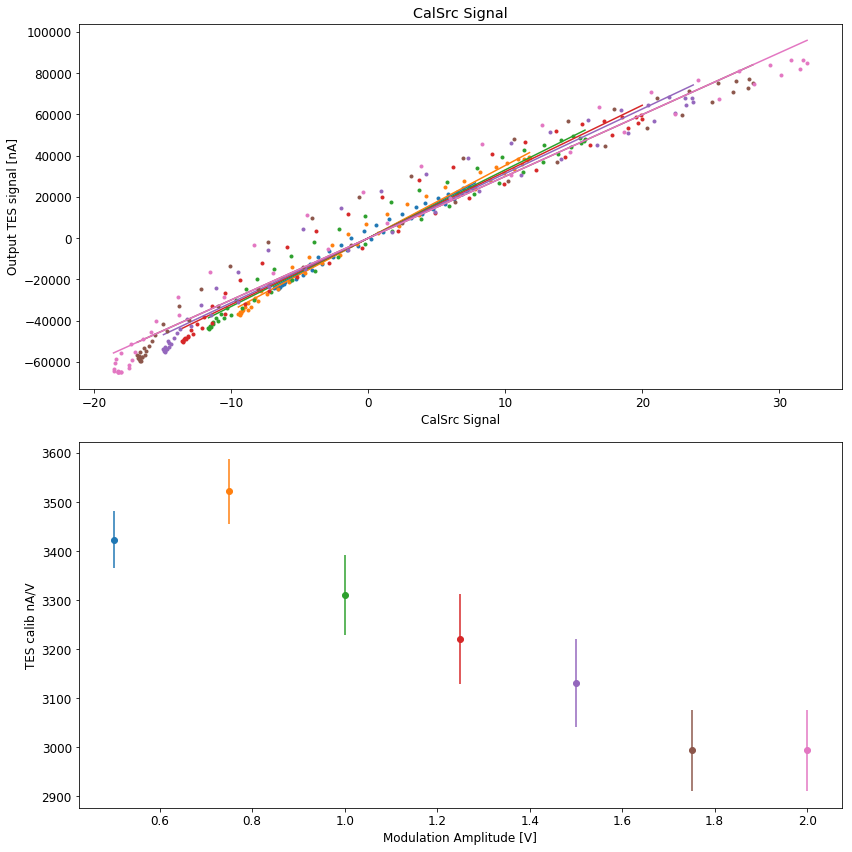

In [224]:
npl = int(np.sqrt(len(tt)))+1
rc('figure',figsize=(12,12))

for ii in xrange(len(tt)):
    subplot(2,1,1)
    params = np.array([amps[ii]/2, 1./modfreqs[ii], allresfit[ii,2]])
    if input_type=='Fitted sinewave':
        input_curve = sine(t, params)+offsets[ii]
    else:
        input_curve = -allfolded_src[ii,:]

    p=plot(input_curve, allfolded[ii,:], '.')
    xxx = np.linspace(np.min(input_curve),np.max(input_curve),100)
    plot(xxx, ft.thepolynomial(xxx, allres[:,ii]), color=p[0].get_color())
    xlabel(input_type)
    ylabel('Output TES signal [nA]')
    title(input_type)
    
    subplot(2,1,2)
    errorbar(amps[ii], allres[0,ii], yerr=allerr[0,ii],fmt='o', color=p[0].get_color())
    xlabel('Modulation Amplitude [V]')
    ylabel('TES calib nA/V')

tight_layout()